# Orchestrate, Deploy and Monitor an AWS Machine Learning workflow for Image Classification

## Solution by: Femi Bolarinwa

## Setting up this notebook on Amazon Sagemaker Studio

instance size and kernel setup:

1. `Python 3 (Data Science)` kernel
2. `ml.t3.medium` Sagemaker notebook instance

## Data Staging

I'll be using a sample dataset (CIFAR) to simulate the challenges Scones Unlimited are facing in Image Classification. In order to start working with CIFAR I'll need to:

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
3. Load it into a production system

In other words, i'm going to do some ETL!

### 1. Extracting the data from the hosting service

In the cell below, i define a function `extract_cifar_data` that extracts python version of the CIFAR-100 dataset. The CIFAR dataaset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 

In [2]:
import requests

def extract_cifar_data(url, filename="cifar.tar.gz"):
    """A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    
    """
    
    # requesting the data from the data url
    r = requests.get(url)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return

Running the following cell to create a new file `cifar.tar.gz` in the file explorer.

In [3]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")     

### 2. Transforming the data into a usable shape and format

The following cell decompresses the extracted dataset:

In [4]:
import tarfile

with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

A new folder `cifar-100-python` is created, containing `meta`, `test`, and `train` files. These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them. I've adapted the script below to run:

In [5]:
import pickle

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [6]:
# exploring the datasets

print(dataset_train.keys())
print(dataset_test.keys())
print(dataset_meta.keys())

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
dict_keys([b'fine_label_names', b'coarse_label_names'])


As documented on the CIFAR homepage, `b'data'` contains rows of 3073 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row.

In [7]:
32*32*3

3072

For a simple gut-check, i'll transform one of our images. Each 1024 items in a row is a channel (red, green, then blue). Each 32 items in the channel are a row in the 32x32 image. Using python, i can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [8]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))

A concise version looks like:

In [9]:
# All in one:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

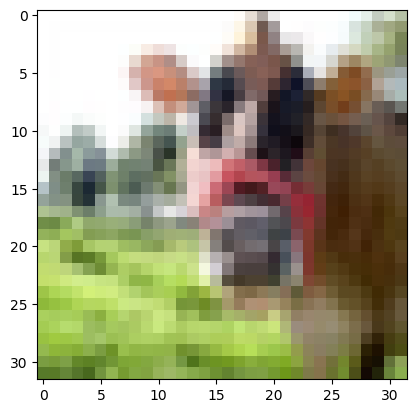

In [10]:
#visualizing sample image

import matplotlib.pyplot as plt
plt.imshow(test_image);
plt.show()

Looks like a cow! i'll check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

In [11]:
dataset_train[b'fine_labels'][0]

19

Our image has a label of `19`, so let's see what the 19th item is in the list of label names.

In [12]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


Ok! 'cattle' sounds about right. By the way, using the previous two lines i can easily do:

In [13]:
n = 0
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][n]])

b'cattle'


Now we know how to check labels, i'll also check file names. `dataset_train` also contains a `b'filenames'` key. Let's see what we have here:

In [14]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


"Taurus" is the name of a subspecies of cattle, so this looks like a pretty reasonable filename. I'll save the image:

In [15]:
plt.imsave("file.png", test_image)

A new PNG file now appears in the file explorer.

I'll capture all the bicycles and motorcycles and save them. Scones Unlimited can use a model that tells these apart to route delivery drivers automatically.

In the following cell, i'll identify the label numbers for Bicycles and Motorcycles:

In [16]:
import pandas as pd

#label numbers for Bicycle and Motorcycles
print(dataset_meta[b'fine_label_names'].index(b'bicycle'))
print(dataset_meta[b'fine_label_names'].index(b'motorcycle'))


8
48


I only need objects with label 8 and 48 -- this drastically simplifies handling of the data! 
Below i'll construct a dataframe, and safely drop the rows that don't contain observations about bicycles and motorcycles. 

In [17]:
#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames'])),
    #"img_data": dataset_train[b'data']
})

# Drop all rows from df_train where label is not 8 or 48

a = [8, 48]

df_train = df_train.loc[df_train['labels'].isin(a)]
#df_train = df_train.loc[df_train["filenames"].isin(my_list)]

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)


df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames'])),
    #"img_data": dataset_test[b'data']
})

# Drop all rows from df_test where label is not 8 or 48
df_test = df_test[df_test['labels'].isin(a)]

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

Now that the data is filtered for just our classes, i'll save all our images.

In [18]:
!mkdir ./train
!mkdir ./test

mkdir: cannot create directory ‘./train’: File exists
mkdir: cannot create directory ‘./test’: File exists


In the previous sections i used several key snippets of code:

1. Grabbing the image data:

```python
dataset_train[b'data'][0]
```

2. A simple idiom for stacking the image data into the right shape

```python
import numpy as np
np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))
```

3. A simple `matplotlib` utility for saving images

```python
plt.imsave(path+row['filenames'], target)
```

I'll compose these together into a function that saves all the images into the `./test` and `./train` directories.


In [19]:
def save_images(dataset, path, df):
    #Grab the image data in row-major form
    for x in df['row']:
        img = dataset[b'data'][x]
    
    # Consolidated stacking/reshaping from earlier
        target = np.dstack((
            img[0:1024].reshape(32,32),
            img[1024:2048].reshape(32,32),
            img[2048:].reshape(32,32)
        ))
    
    # Save the image
        plt.imsave(path+'/'+df['filenames'][x], target)
    
    #
    return

In [20]:
#saving all train images:
save_images(dataset=dataset_train, path="./train", df=df_train)
#saving all test images:
save_images(dataset=dataset_test, path="./test", df=df_test)

In [21]:
#size of train dataset
len(df_train)

1000

### 3. Loading the data

Now i'll load the data into S3.

Using the sagemaker SDK, i'll grab the current region, execution role, and bucket.

In [22]:
import sagemaker

#from sagemaker.session import Session
from sagemaker import get_execution_role

session = sagemaker.Session()

bucket= session.default_bucket() 
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-678515801283
AWS Region: us-east-1
RoleArn: arn:aws:iam::678515801283:role/service-role/AmazonSageMaker-ExecutionRole-20231023T105833


Now i'll easily sync the data up into S3!

In [23]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/

upload: train/bicycle_s_000017.png to s3://sagemaker-us-east-1-678515801283/train/bicycle_s_000017.png
upload: train/bicycle_s_000043.png to s3://sagemaker-us-east-1-678515801283/train/bicycle_s_000043.png
upload: train/bicycle_s_000035.png to s3://sagemaker-us-east-1-678515801283/train/bicycle_s_000035.png
upload: train/bicycle_s_000051.png to s3://sagemaker-us-east-1-678515801283/train/bicycle_s_000051.png
upload: train/bicycle_s_000021.png to s3://sagemaker-us-east-1-678515801283/train/bicycle_s_000021.png
upload: train/bicycle_s_000038.png to s3://sagemaker-us-east-1-678515801283/train/bicycle_s_000038.png
upload: train/bicycle_s_000124.png to s3://sagemaker-us-east-1-678515801283/train/bicycle_s_000124.png
upload: train/bicycle_s_000147.png to s3://sagemaker-us-east-1-678515801283/train/bicycle_s_000147.png
upload: train/bicycle_s_000039.png to s3://sagemaker-us-east-1-678515801283/train/bicycle_s_000039.png
upload: train/bicycle_s_000156.png to s3://sagemaker-us-east-1-6785158012

I verified that the items were uploaded.

## Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths. I'll generate these using our Pandas DataFrames from earlier:

In [24]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

I'll also upload our manifest files:

In [25]:
import boto3

# Upload files
boto3.Session().resource('s3').Bucket(
    bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('test.lst').upload_file('./test.lst')

Using the `bucket` and `region` info i can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model. I'll use the `image_uris` function from the SageMaker SDK to retrieve the latest `image-classification` image below:

In [26]:
from sagemaker import image_uris

# i'll use the image_uris function to retrieve the latest 'image-classification' image 
algo_image = image_uris.retrieve(framework='image-classification',region=region, version='latest')

##defining s3 bucket location to save data
s3_output_location = f"s3://{bucket}/models/image_model"

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


I'll create a sagemaker estimator `img_classifier_model` that uses one instance of `ml.p2xlarge`. I'll use the output location defined above:

In [27]:
import sagemaker
import boto3 

img_classifier_model=sagemaker.estimator.Estimator(image_uri=algo_image, 
                              role=role, 
                              instance_count=1,
                              instance_type='ml.p2.xlarge',
                              output_path=s3_output_location,
                              sagemaker_session=session
)

/opt/conda/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


I'll also set a few key hyperparameters and define the inputs for our model:

In [28]:
img_classifier_model.set_hyperparameters(
    image_shape="3,32,32",
    num_classes=2,
    num_training_samples= len(df_train)
)

The `image-classification` image uses four input channels with very specific input parameters shown below:

In [29]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}

Now i'll train the model using model_inputs. In the cell below, i'll call the `fit` method on our model,:

In [30]:
## Training my model
img_classifier_model.fit(model_inputs,wait=True)

INFO:sagemaker:Creating training-job with name: image-classification-2023-10-26-19-22-40-843


2023-10-26 19:22:40 Starting - Starting the training job......
2023-10-26 19:23:16 Starting - Preparing the instances for training.........
2023-10-26 19:24:45 Downloading - Downloading input data...
2023-10-26 19:25:21 Training - Downloading the training image.....................
2023-10-26 19:28:57 Training - Training image download completed. Training in progress......Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Thu Oct 26 19:29:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|    

I was able to achieve a model topping above `80%` validation accuracy. With only 1000 training samples in the CIFAR dataset, that's pretty good. I could definitely pursue data augmentation & gathering more samples to help improve further, but for now i'll proceed to deploy our model.

### Sagemaker Model Deployment 

To begin with, i'll configure Model Monitor to track performance drift at model endpoint. i'll define a `DataCaptureConfig` below:

In [42]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    ##Set config options
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=f"s3://{bucket}/data_capture"
)

Note the `destination_s3_uri` parameter: At the end of the project, i'll explore the `data_capture` directory in S3 to find crucial data about the inputs and outputs Model Monitor has observed on our model endpoint over time.

With that done, i'll deploy my model on a single `ml.m4.xlarge` instance with the data capture config attached:

In [43]:
deployment = img_classifier_model.deploy(
    #deployment options
    initial_instance_count=1, 
    instance_type='ml.m4.xlarge',
    data_capture_config=data_capture_config
    )

endpoint = deployment.endpoint_name
print(endpoint)

INFO:sagemaker:Creating model with name: image-classification-2023-10-26-20-15-10-544
INFO:sagemaker:Creating endpoint-config with name image-classification-2023-10-26-20-15-10-544
INFO:sagemaker:Creating endpoint with name image-classification-2023-10-26-20-15-10-544


---------------!image-classification-2023-10-26-20-15-10-544


Note the endpoint name for later as well.

Next, i'll instantiate a Predictor:

In [45]:
predictor = sagemaker.predictor.Predictor(
    endpoint,
    sagemaker_session=sagemaker.Session(),
)

In the code snippet below i'm going to prepare one of your saved images for sample prediction. i'll use the predictor to process the `payload`:

In [46]:
from sagemaker.serializers import IdentitySerializer
import base64

#initializing predictor serializer
predictor.serializer = IdentitySerializer("image/png")

#serializing the sample test image
with open("./test/minibike_s_001441.png", "rb") as f:
    payload = f.read()
    
#making a prediction with thr predictor
inference = predictor.predict(payload) 

In [47]:
print(inference)

b'[0.0009108324302360415, 0.9990891218185425]'


The `inference` object is an array of two values, the predicted probability value for each of our classes (bicycle and motorcycle respectively.) So, for example, a value of `b'[0.91, 0.09]'` indicates the probability of being a bike is 91% and being a motorcycle is 9%.

### Lambdas and Step Function Workflow to Run and Monitor Sagemaker Model Endpoint Invocation

Step Functions are used to orchestrate serverless workflows. One of the nice things about Step Functions is that [workflows can call other workflows](https://docs.aws.amazon.com/step-functions/latest/dg/connect-stepfunctions.html), so the team can easily plug your workflow into the broader production architecture for Scones Unlimited.

In this next stage i'm going to write and deploy three Lambda functions, and then use the AWS Step Functions visual editor to chain them together! My functions are going to work with a simple data object like this:

```python
{
    "inferences": [], # Output of predictor.predict
    "s3_key": "", # Source data S3 key
    "s3_bucket": "", # Source data S3 bucket
    "image_data": ""  # base64 encoded string containing the image data
}
```

A good test object that i'll use for Lambda tests and Step Function executions, throughout the next section, looks like this:

```python
{
  "image_data": "",
  "s3_bucket": "sagemaker-us-east-1-678515801283"
  "s3_key": "test/bicycle_s_000513.png"
}
```

Using these fields, my lambda functions can read and write the necessary data to execute the workflow. 
My first Lambda function will copy an object from S3, base64 encode it, and then return it to the step function as `image_data` in an event.

In the AWS Lambda dashboard, i created a new Lambda function with a descriptive "serializeImageData", 'Python 3.8' runtime. Added an IAM role with full S3 access and BasicLambdaExecution permissions/policies. My Lambda function looks like this:

```python
import json
import boto3
import base64

s3 = boto3.client('s3')

def lambda_handler(event, context):
    """A function to serialize target data from S3"""
    
    # s3 bucket address from the Step Function event input
    key = event["s3_key"]
    bucket = event["s3_bucket"]
    
    # Downloading the image data from s3 to /tmp/image.png
    boto3.resource('s3').Bucket(bucket).download_file(key, "/tmp/image.png")
    
    #read the data from a file
    with open("/tmp/image.png", "rb") as f:
        image_data = base64.b64encode(f.read())

    #Pass the data back to the Step Function
    event["image_data"] = image_data #FB
    print(event)
    print("Event:", event.keys())
    return {
        'statusCode': 200,
        'body': {
            "image_data": image_data,
            "s3_bucket": bucket,
            "s3_key": key,
            "inferences": []
        }
    }
```

The next function is responsible for the classification part - i'm going to take the image output from the previous function, decode it, and then pass inferences back to the the Step Function.

My second Lambda function has the same IAM role and a descriptive name (classifyImageData). My Lambda function looks like this:

```python
import boto3
import json
import base64

# name of your deployed model endpoint on sagemaker
endpoint = "image-classification-2023-10-26-20-15-10-544" 

def lambda_handler(event, context):
    """A function to run inference on image data using sagemaker endpoint"""

    # grab and decode the image data from the response body of previous lambda function in the Step Function
    body = event['body']
    
    image = base64.b64decode(body["image_data"])
     
    #invoking sagemaker endpoint to make prediction
    runtime = boto3.Session().client('sagemaker-runtime')
    response = runtime.invoke_endpoint(EndpointName=endpoint, ContentType = 'image/png',Body = image)
    predictions = json.loads(response['Body'].read().decode())
    
    #attach inference to event and pass the data back to the Step Function
    event["inferences"] = predictions    
    print(event)
    
    return {
        'statusCode': 200,
        'body': event #json.dumps(event)
    }
```

Finally, i need to filter low-confidence inferences. I defined a threshold of 0.8. If the model predicts at `80%` or higher for it's highest confidence label, the step function will pass that inference along to downstream systems. 

My third Lambda function has the same IAM role and a descriptive name (filterInference). My Lambda function looks like this:


```python
import json


THRESHOLD = 0.8


def lambda_handler(event, context):
    """A function to filter out low-confidence inferences"""
    
    # Grab the inferences from the event (response body) of previous lambda function in the Step Function
    body = event['body']
    
    inferences = body["inferences"]
    
    # Check if any values in our inferences are above THRESHOLD
    meets_threshold = any (x >= THRESHOLD for x in inferences)
    
    # If our threshold is met, pass our data back out of the...
    # Step Function, else, end the Step Function and raise an error
    
    if meets_threshold:
        pass
    else:
        raise("THRESHOLD_CONFIDENCE_NOT_MET")
    
    return {
        'statusCode': 200,
        'body': event #json.dumps(event)
    }
```

With your lambdas in place, i'll now use the Step Functions visual editor to construct a workflow that chains them together.


Now i can use the S3 image files in `./test` as test files for the workflow. The workflow should reliably pass predictions about images from `./test` on to downstream systems if the threshold is met, while erroring out for inferences below our confidence threshold!

### Testing and Evaluation

I'll do several step function invokations using data from the `./test` folder. This process should give confidence that the workflow both *succeeds* AND *fails* as expected. In addition, SageMaker Model Monitor will generate recordings of your data and inferences which we can visualize since we deployed the endpoint with a DataCaptureConfig.

Below is a function that can generate test inputs for the endpoint invokations:

In [55]:
import random
import boto3
import json


def generate_test_case():
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Randomly pick from sfn or test folders in our bucket
    objects = s3.Bucket(bucket).objects.filter(Prefix='test')
    
    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in objects])
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    })


generate_test_case()

'{"image_data": "", "s3_bucket": "sagemaker-us-east-1-678515801283", "s3_key": "test/safety_bike_s_000540.png"}'

In the AWS Step Function dashboard for our new workflow, i created new executions and copy in the generated test cases. I did  several executions so to generate inference data that can be evaluated and visualized.

I'll visualize the record of our inferences by first pulling in the JSONLines data from my inferences/invocations:

In [57]:
from sagemaker.s3 import S3Downloader

# In S3 Sagemaker model monitor will save data capture in datetime-aware path
data_path = f"s3://{bucket}/data_capture/image-classification-2023-10-26-20-15-10-544"
S3Downloader.download(data_path, "captured_data")


['captured_data/AllTraffic/2023/10/26/20/26-30-363-6485cdd2-f535-4072-9d5a-edbb58f85cb4.jsonl',
 'captured_data/AllTraffic/2023/10/26/20/29-43-319-4aae16b8-adf7-4794-a13d-94ac9b49b796.jsonl',
 'captured_data/AllTraffic/2023/10/26/20/32-33-662-f6a62a66-5e5e-4f81-a5cd-a424dd6da8f4.jsonl',
 'captured_data/AllTraffic/2023/10/26/20/33-37-987-23aaadb0-da37-4d65-b786-a164e518b093.jsonl',
 'captured_data/AllTraffic/2023/10/26/20/38-12-354-68591337-3a00-4ba8-9551-e58d78ea9a5e.jsonl',
 'captured_data/AllTraffic/2023/10/26/20/39-15-445-aa15a92d-1424-41b7-a995-6f9b79e22b36.jsonl']

The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file. We'll import an open-source library, `jsonlines` that was purpose built for parsing this format.

In [60]:
!pip install jsonlines
import jsonlines

  Using cached jsonlines-3.1.0-py3-none-any.whl (8.6 kB)
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


Now we can extract the data from each of the source files:

In [62]:
import os

# List the file names we downloaded
file_handles = os.listdir("./captured_data/AllTraffic/2023/10/26/20")

file_handles = [handle for handle in file_handles if handle != ".ipynb_checkpoints"] #FB

# Dump all the data into an array
json_data = []
for jsonl in file_handles:
    with jsonlines.open(f"./captured_data/AllTraffic//2023/10/26/20/{jsonl}") as f:
        json_data.append(f.read())

The data should now be a list of dictionaries, with significant nesting. Code below grabs data out of the objects and visualizes it:

In [68]:
# Define how we'll get our inference data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

simple_getter(json_data[0])

([0.9566223621368408, 0.043377626687288284], '2023-10-26T20:39:15Z')

the inference data captured by sagemaker model monitor has the input images, the resulting inferences, and the timestamps.

### Visualization of inference data captured by sagemaker model monitor 


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


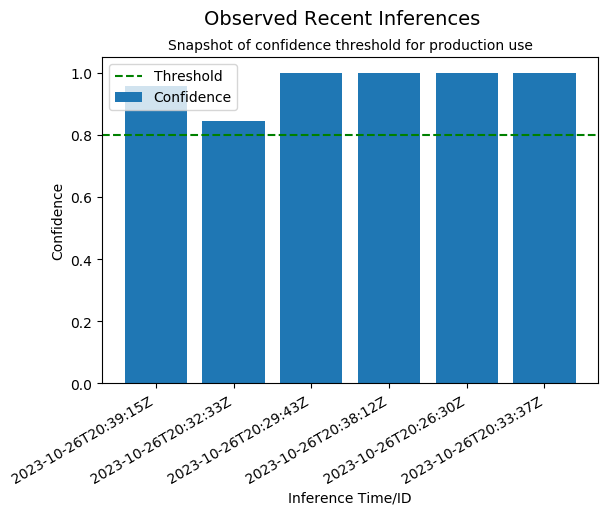

In [69]:
import matplotlib.pyplot as plt
# Populate the data for the x and y axis
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    
    y.append(max(inference))
    x.append(timestamp)

# Plot the data
plt.bar(x, y)#, c=['r' if k<.94 else 'b' for k in y ])
plt.axhline(y=0.8, color='g', linestyle='--')
#plt.ylim(bottom=.88)

# Add labels
plt.ylabel("Confidence")
plt.xlabel("Inference Time/ID")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Snapshot of confidence threshold for production use", size=10)
plt.legend(['Threshold','Confidence'])

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()
plt.show()

### Conclusion

In this project i created an event-driven AWS Machine learning workflow that can be incorporated into production architecture.

I executed a model training job on AWS and used the Amazon SageMaker Estimator API to deploy a SageMaker Model and Endpoint. I used AWS Lambda and Step Functions to orchestrate my ML workflow. Using SageMaker Model Monitor, i instrumented and observed my deployed Endpoint, and at the end of the project i built a visualization to help stakeholders understand the performance of the Endpoint over time. 

